# Quick Pyrap Tutorial - Etienne Bonnassieux

### If you have any questions or comments, please feel free to send an email to etienne.bonnassieux@obspm.fr

The aim of this notebook is to show how to open, read, and manipulate measurement sets using pyrap. We will do the same sort of manipulation that one would do with casabrowser, albeit in a much more easily portable way: using these features in python scripts and programs is very straightforward.

Pyrap is powerful, quick and modular; note that here, we only play with the "table" module, but pyrap also allows for fits manipulation (if, say, you want to average your data in the image plane, pyrap.images.image can be of great help) and other things of relevance to our interests.


In [1]:
# begin by importing modules
from pyrap.tables import table
import numpy as np
import pylab
# make sure plots happen within the notebook
%matplotlib inline

Let us begin by opening a measurement set. The readonly=True option means that we cannot modify the table; this is useful when one wants to mess about with the MS, or is unsure of what they are doing.

In [2]:
msname="/home/offler/offler/ALGO/TestReadMS/DATA/Simul_one_beam_off.MS"
ms=table(msname,readonly=True)

Successful readonly open of default-locked table /home/offler/offler/ALGO/TestReadMS/DATA/Simul_one_beam_off.MS: 28 columns, 938730 rows


Note that once the table object is created (in our case, ms), it has multiple options. In a notebook, these can be seen by typing "ms." and attempting a tab-complete (i.e. pressing tab). This should create a drop-down menu showing all the available
functions and methods associated with the object. Here, we will begin by looking at the actual contents of the measurement set.

In [3]:
# This function returns the names of all the columns in the MS.
ms.colnames()

['UVW',
 'FLAG_CATEGORY',
 'WEIGHT',
 'SIGMA',
 'ANTENNA1',
 'ANTENNA2',
 'ARRAY_ID',
 'DATA_DESC_ID',
 'EXPOSURE',
 'FEED1',
 'FEED2',
 'FIELD_ID',
 'FLAG_ROW',
 'INTERVAL',
 'OBSERVATION_ID',
 'PROCESSOR_ID',
 'SCAN_NUMBER',
 'STATE_ID',
 'TIME',
 'TIME_CENTROID',
 'DATA',
 'FLAG',
 'LOFAR_FULL_RES_FLAG',
 'WEIGHT_SPECTRUM',
 'MODEL_DATA',
 'CORRECTED_DATA',
 'IMAGING_WEIGHT',
 'FLAG_BACKUP']

One column of interest contains the UV tracks of our observation: "UVW". Let us read and plot them.

In [4]:
# load u and v tracks. Putting w into _ means that the values are essentially discarded.
u,v,_=ms.getcol("UVW").T

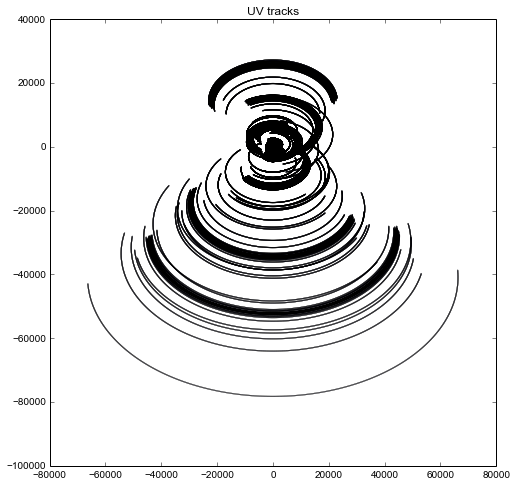

In [5]:
# Let us make a scatter plot of all the UV tracks. s=0.01 means that we want tiny points.
pylab.figure(figsize=(8,8))
pylab.title("UV tracks")
pylab.scatter(u,v,s=0.01)
pylab.show()

Remember, this is actually only half the UV coverage! These are only the baselines going one way (e.g. A1  to A2), but of course we also know what our visibilities are on the baselines going the other way (A2 to A1); these are not stored because they are simply the complex conjugate. If we want to see the entire UV coverage, we must therefore plot both U vs V but also -U vs -V, as below:

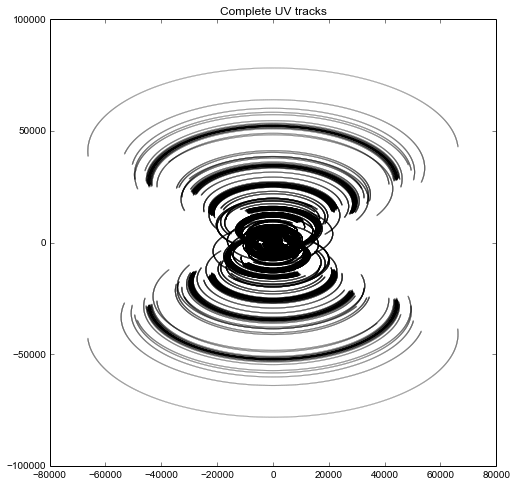

In [6]:
pylab.figure(figsize=(8,8))
pylab.title("Complete UV tracks")
pylab.scatter(u,v,s=0.001)
pylab.scatter(-u,-v,s=0.001)
pylab.show()

Now, let's look at the instantaneous UV coverage; Let us load the time column, to read only the data from the first timestep (any arbitrary timestep should do; I am choosing one I am certain exists!)

In [10]:
time=ms.getcol("TIME")

Here, we are applying a mask to our array so as to efficiently load only the u,v values of the relevant time. Being able to do this is one of the great  strengths of numpy!

In [11]:
u0 = u[time==time[0]]
v0 = v[time==time[0]]

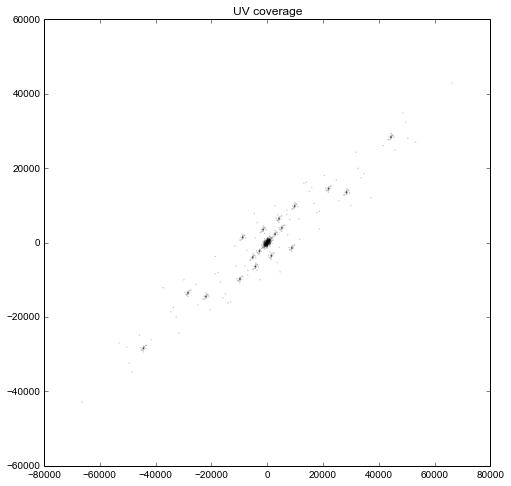

In [12]:
# Again, we will make a scatter of what is now our instantaneous coverage.
pylab.figure(figsize=(8,8))
pylab.title("UV coverage")
pylab.scatter(u0,v0,s=0.01)
pylab.scatter(-u0,-v0,s=0.01)
pylab.show()

How would we apply the flags to our UV coverage in order to know what our *actual* coverage is, rather than our *ideal* coverage?

In [13]:
# Let's load our flag arrays and look at their shapes.
flags=ms.getcol("FLAG")
flags0=flags[time==time[0]]
print flags.shape
print flags0.shape
test=np.array([0,0,1,0])
test1=np.array([1,2,3,4])
print test1
print test==0
test1[test==10]

(938730, 1, 4)
(435, 1, 4)
[1 2 3 4]
[ True  True False  True]


array([], dtype=int64)

What does this tell us? We have three dimensions here: Ndata, Nchan, Npol. Ndata for the full array corresponds to Ntimesteps*Nbaselines; for our flags0 array, we have Ntimes=0 (by construction) and Ndata is thus the number  of baselines in this observation. Nchan is the number of channels in this dataset. Npol is the number of polarisations in this dataset; usually 4.

We now want to apply our flags to our UV tracks and see  what our actual UV coverage was over the entire observation, and an arbitrary time, e.g. start of observation. Because our u,v arrays are of shape Nbaselines*Ntimes, we will look at the UV coverage for 1 polarisation and 1 channel only. Thankfully, we only have 1 channel to begin with, but recasting will still be necessary.

Here, we take all of the first dimension (Nt\*Nbl), and only the 0th element of the 2nd (chan) and 3rd (pola) dimensions. This gives us a 1-dimensional array of size Ntimes*Nbaselines for uvflags and Nbaselines for uv0flags.

In [8]:
uvflags=flags[:,0,0]
uv0flags=flags[time==time[0]][:,0,0]

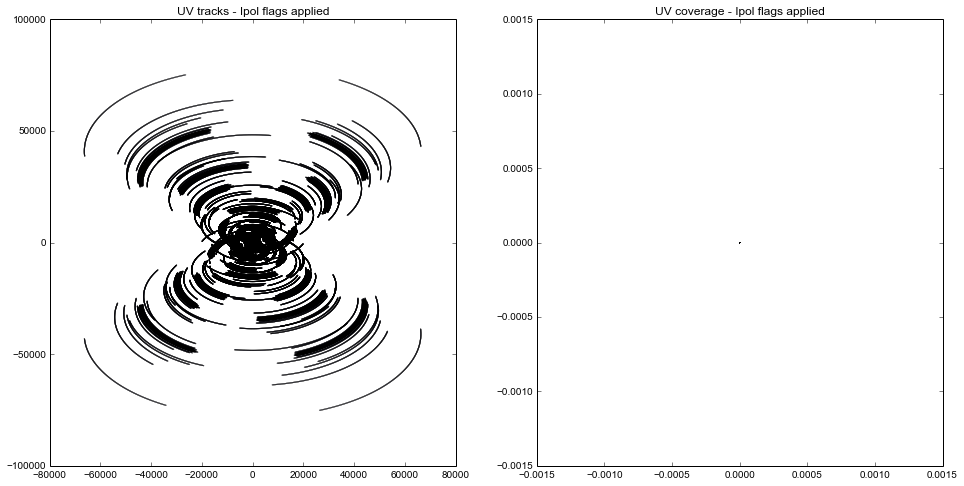

In [12]:
# As before, let us now plot these!
pylab.figure(figsize=(16,8))
pylab.subplot(1,2,1)
pylab.title("UV tracks - Ipol flags applied")
pylab.scatter(u[uvflags==False],v[uvflags==False],s=0.01)
pylab.scatter(-u[uvflags==False],-v[uvflags==False],s=0.01)
pylab.subplot(1,2,2)
pylab.title("UV coverage - Ipol flags applied")
pylab.scatter(u0[uv0flags==False],v0[uv0flags==False],s=0.01)
pylab.scatter(-u0[uv0flags==False],-v0[uv0flags==False],s=0.01)
pylab.show()

Let us now read the data columns. Look at its dimensionality again:

In [9]:
# read corrected data column
print ms.getcol("CORRECTED_DATA").shape

(938730, 1, 4)


Now, choose an antenna pair and look at the data array shape.

In [14]:
# choose an antenna pair; ant1 > ant2
ant1=15
ant2=4
A1=ms.getcol("ANTENNA1")
A2=ms.getcol("ANTENNA2")
ind=np.where((A1==ant1)&(A2==ant2))
print ms.getcol("CORRECTED_DATA")[ind].shape
print time[ind].ravel().size

(2158, 1, 4)
2158


Note that we now know the number of timesteps in our observation. Let us plot the corresponding data, both amplitude (real) and phase (imaginary):

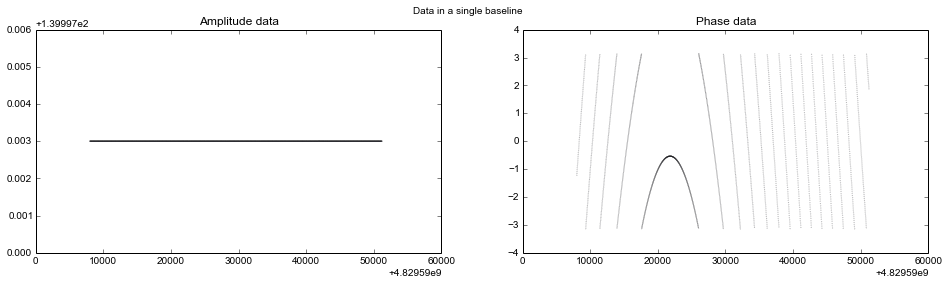

In [15]:
pylab.figure(figsize=(16,4))
pylab.suptitle("Data in a single baseline")
pylab.subplot(1,2,1)
pylab.title("Amplitude data")
pylab.scatter(time[ind].ravel(),np.abs(ms.getcol("CORRECTED_DATA")[ind])[:,0,0],s=0.01)
pylab.subplot(1,2,2)
pylab.title("Phase data")
pylab.scatter(time[ind].ravel(),np.angle(ms.getcol("CORRECTED_DATA")[ind])[:,0,0],s=0.01)
pylab.show()

One convenient thing to know how to do is creating new columns within your measurement set. This is actually somewhat faffy, and so I will give the entire procedure for your copy-pasting convenience.

let us begin by opening the measurement set with readonly=False . This means that changes made to the measurement set will be written to file; make sure you know what you're doing and have already made a backup!!!

In [16]:
ms=table(msname,readonly=False)
# Let's look at the list of columns in our MS.
print "Before:"
print ms.colnames()

Successful read/write open of default-locked table /home/offler/offler/ALGO/TestReadMS/DATA/Simul_one_beam_off.MS: 28 columns, 938730 rows
Before:
['UVW', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'FLAG', 'LOFAR_FULL_RES_FLAG', 'WEIGHT_SPECTRUM', 'MODEL_DATA', 'CORRECTED_DATA', 'IMAGING_WEIGHT', 'FLAG_BACKUP']


Let's begin doing the faffy stuff we need. A column needs a coldesc in order for the MS to know what it is. We will therefore copy the coldesc from a similar column (e.g. DATA if you're making a backup,  WEIGHT if you want to implement your own weighting scheme, FLAG if you're playing with flagging).

In [17]:
desc=ms.getcoldesc("CORRECTED_DATA")
# Change the "name" value of your desc to whatever you want to call your new column
desc["name"]="CORRECTED_BACKUP"
# this is technical faff, whitespaces are doubleplus ungood
desc['comment']=desc['comment'].replace(" ","_")
# add your column to your measurement set
ms.addcols(desc)
# fill it with delicious numbers
ms.putcol("CORRECTED_BACKUP",ms.getcol("CORRECTED_DATA"))
# Your column has now been added to your measurement set, and is the last entry in ms.colnames()
print "After:"
print ms.colnames()

After:
['UVW', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'FLAG', 'LOFAR_FULL_RES_FLAG', 'WEIGHT_SPECTRUM', 'MODEL_DATA', 'CORRECTED_DATA', 'IMAGING_WEIGHT', 'FLAG_BACKUP', 'CORRECTED_BACKUP']


Now that we know how to create and fill a table in our MS, let's find out how to delete it, e.g. if you are running out of disk space because you went mad with power and made fifteen separate backups of your CORRECTED_DATA column. In such circumstances, it is wise to clean up your mess before your supervisor and/or sysadmin discovers the dire consequences of your hubris...

Open the measurement set again, but this time set readonly=False : you are now playing with fire!!!

In [18]:
ms=table(msname,readonly=False)
print "Before:"
print ms.colnames()
# use the handy-dandy removecols method
ms.removecols("CORRECTED_BACKUP")
print "After:"
print ms.colnames()

Successful read/write open of default-locked table /home/offler/offler/ALGO/TestReadMS/DATA/Simul_one_beam_off.MS: 29 columns, 938730 rows
Before:
['UVW', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'FLAG', 'LOFAR_FULL_RES_FLAG', 'WEIGHT_SPECTRUM', 'MODEL_DATA', 'CORRECTED_DATA', 'IMAGING_WEIGHT', 'FLAG_BACKUP', 'CORRECTED_BACKUP']
After:
['UVW', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'FLAG', 'LOFAR_FULL_RES_FLAG', 'WEIGHT_SPECTRUM', 'MODEL_DATA', 'CORRECTED_DATA', 'IMAGING_WEIGHT', 'FLAG_BACKUP']


As you can see, our CORRECTED_BACKUP column is no longer part of ms.colnames(); it has been removed.

Note that because of the need for a coldesc, adding a column is much faffier than removing one; this is why I recommend writing a function of the form AddMScol(NewColName,RefColName) where RefColName is the name of the column you're copying (e.g. WEIGHT, DATA, whatever) and NewColName is the name of your new column.

Finally, DO NOT FORGET to CLOSE your measurement set!

In [19]:
# !!! IMPORTANT !!!
ms.close()

If you don't, you will not restore the locks on the ms file, and this will likely cause your calibration software to wait for ages for those locks to be restored, costing you precious precious time.

 Your own time is your most precious resource!!!

Now, you will see how I kitbash RFI flagging (assuming it is 100% effective) using pyrap. I did this over 20min during lunch break for a Tuesday presentation; it is related to the above only as a practical example of the sort of shenanigans one can get up to with pyrap!

In [17]:
# let us now kitbash a RFI simulator
ms=table(msname,readonly=False)
ndata=ms.getcol("DATA").shape[0]
nfreq=ms.getcol("DATA").shape[1]
print "number of channels: %i"%nfreq
# put RFI on random channels
nchanRFI= np.random.random_integers(0.1*nfreq,0.3*nfreq)
# make sure at least one channel is flagged
if nchanRFI<1:
    nchanRFI=1
print "number of channels affected by RFI: %i"%nchanRFI
# randomise extent of RFI for each channel
ntRFI=np.array([])
RFIstart=np.array([])
for i in range(nchanRFI):
    ntRFI=np.append(ntRFI,np.random.random_integers(0.2*ndata,0.7*ndata))
    RFIstart=np.append(RFIstart,np.random.random_integers(0,ndata-ntRFI[i]))
#print ntRFI/ndata
#print RFIstart/ndata
# flag our artificial RFI
flags=ms.getcol("FLAG")
# make backup column first
if "FLAG_BACKUP" not in ms.colnames():
    print "make backup"
    desc=ms.getcoldesc("FLAG")
    desc["name"]="FLAG_BACKUP"
    ms.addcols(desc)
    ms.putcol("FLAG_BACKUP",flags)
else:
    print "backup already there"
print RFIstart.shape
#print flags[RFIstart:ntRFI,0,0].shape
for i in range(flags.shape[1]):
    print i
    # flag RFI on top of whatever was flagged in the first place
    print flags.shape
    print i
    print RFIstart[i]
    print ntRFI[i]
    flags[RFIstart[i]:(RFIstart[i]+ntRFI[i]),i,:]=1
ms.putcol("FLAG",flags)
ms.close()

Successful read/write open of default-locked table /home/offler/offler/ALGO/TestReadMS/DATA/Simul_one_beam_off.MS: 28 columns, 938730 rows
number of channels: 1
number of channels affected by RFI: 1
backup already there
(1,)
0
(938730, 1, 4)
0
522525.0
325827.0
